# Clasificación de ciberbullying

**Nombre:** Leobardo García Reyes

**Matrícula:** 1616825

# Librerías

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from IPython.display import display

import re, string, unicodedata
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet

from textblob import TextBlob
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.corpus import sentiwordnet as swn

from sklearn.feature_selection import chi2
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn import metrics


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
nltk.download('punkt') # Descargar tokenizar
nltk.download('stopwords') # Descargar stopwords
nltk.download('wordnet') # Descargar lematización
nltk.download('averaged_perceptron_tagger')
nltk.download('sentiwordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


True

# Carga de datos

## Lectura de datos

In [24]:
Datos = pd.read_csv('/content/drive/MyDrive/Tarea 3/cyberbullying_tweets.csv', encoding = 'latin-1')
Datos.head(2)

,tweet_text,cyberbullying_type
0,Having some real sympathy for Twitter right now.,other_cyberbullying
1,The final is in November #MKR,other_cyberbullying


## Manipulación de datos

In [25]:
#Datos.rename(columns = {'tweet_text': 'Texto', 'cyberbullying_type': 'Tipo_Bullying'}).head(2)
TText = pd.DataFrame({'Texto': Datos['tweet_text'], 'Tipo_Bullying': Datos['cyberbullying_type']})
TText.head()

,Texto,Tipo_Bullying
0,Having some real sympathy for Twitter right now.,other_cyberbullying
1,The final is in November #MKR,other_cyberbullying
2,"RT @LouisRITHPotter I'm not sexist, but someti...",gender
3,@MrAlMubarak Allah the terrorist can stick wha...,religion
4,@Sushilulutwitch @Spacekatgal Glad to hear fro...,not_cyberbullying


In [26]:
# Dimensión de los datos y nombre de columnas
print('Dimensiones: {}'.format(TText.shape))
print('\n')
print(TText.columns)

Dimensiones: (47692, 2)


Index(['Texto', 'Tipo_Bullying'], dtype='object')


In [27]:
N = 47692
TText = TText.iloc[:30000, :]
TText.shape

(30000, 2)

# Limpieza de texto

In [28]:
# Función para limpiar texto
def Limpiar_texto(texto):
    # Se convierte todo el texto a minúsculas
    nuevo_texto = texto.lower()

    # Eliminación de páginas web (palabras que empiezan por "http")
    nuevo_texto = re.sub('http\S+', ' ', nuevo_texto)

    # Eliminación de texto en paréntesis
    nuevo_texto = re.sub('([\(\[]).*?([\)\]])', '\g<1>\g<2>', nuevo_texto)

    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    nuevo_texto = re.sub(regex , ' ', nuevo_texto)
    nuevo_texto = re.sub(r'[^\w\s]', '', nuevo_texto)

    # Eliminación de números
    nuevo_texto = re.sub(r'[0-9]+', ' ', nuevo_texto)

    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub('\\s+', ' ', nuevo_texto)
    
    return(nuevo_texto)

In [29]:
# Aplicar la función de limpiza de texto en la columna de texto
TText['Texto_Limpio'] = TText['Texto'].apply(lambda x: Limpiar_texto(x))
TText[['Texto', 'Tipo_Bullying', 'Texto_Limpio']].head(3)

,Texto,Tipo_Bullying,Texto_Limpio
0,Having some real sympathy for Twitter right now.,other_cyberbullying,having some real sympathy for twitter right now
1,The final is in November #MKR,other_cyberbullying,the final is in november mkr
2,"RT @LouisRITHPotter I'm not sexist, but someti...",gender,rt louisrithpotter i m not sexist but sometime...


## Stopwords

In [30]:
# Stopwords en ingles
sw = stopwords.words('english')

# Nuevas stopwords
nuevas_sw = ('one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'amp',
             'rt', 'mkr', 'didn', 'bc', 'n', 'm', 'im', 'll', 'y', 've', 'u', 'ur', 'don', 't', 's')

for i in nuevas_sw:
    sw.append(i)

print(sw)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

## Diccionario POS

In [31]:
# Diccionario de etiquetado POS
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}

# Función que etiqueta cada palabra con verbo, sustantivo, adjetivo, adverbio
# También remueve las stopwords
def token_stop_pos(text):
    tags = pos_tag(word_tokenize(text))
    newlist = []
    for word, tag in tags:
        if word.lower() not in sw:
            newlist.append(tuple([word, pos_dict.get(tag[0])]))
    return(newlist)

TText['Texto_Pos'] = TText['Texto_Limpio'].apply(token_stop_pos)
TText.head(2)

,Texto,Tipo_Bullying,Texto_Limpio,Texto_Pos
0,Having some real sympathy for Twitter right now.,other_cyberbullying,having some real sympathy for twitter right now,"[(real, a), (sympathy, n), (twitter, n), (righ..."
1,The final is in November #MKR,other_cyberbullying,the final is in november mkr,"[(final, a), (november, a)]"


## Lematización

In [32]:
# Método Lematizar
wordnet_lemmatizer = WordNetLemmatizer()

# Función para lematizar cada palabra
def lemmatize(pos_data):
    lemma_rew = ' '
    for word, pos in pos_data:
        if not pos: 
            lemma = word
            lemma_rew = lemma_rew + ' ' + lemma
        else:  
            lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
            lemma_rew = lemma_rew + ' ' + lemma
    return(lemma_rew)
    
TText['Lema'] = TText['Texto_Pos'].apply(lemmatize)
TText.head(2)

,Texto,Tipo_Bullying,Texto_Limpio,Texto_Pos,Lema
0,Having some real sympathy for Twitter right now.,other_cyberbullying,having some real sympathy for twitter right now,"[(real, a), (sympathy, n), (twitter, n), (righ...",real sympathy twitter right
1,The final is in November #MKR,other_cyberbullying,the final is in november mkr,"[(final, a), (november, a)]",final november


In [33]:
def mayores(texto):
    # Se convierte todo el texto a minúsculas
    nuevo_texto = texto.lower()

    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep = ' ')

    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1]
    return(nuevo_texto)

TText['Mayores'] = TText['Lema'].apply(mayores)
TText.head(2)

,Texto,Tipo_Bullying,Texto_Limpio,Texto_Pos,Lema,Mayores
0,Having some real sympathy for Twitter right now.,other_cyberbullying,having some real sympathy for twitter right now,"[(real, a), (sympathy, n), (twitter, n), (righ...",real sympathy twitter right,"[real, sympathy, twitter, right]"
1,The final is in November #MKR,other_cyberbullying,the final is in november mkr,"[(final, a), (november, a)]",final november,"[final, november]"


In [34]:
def lema_mayores(texto):
    juntar = ' '
    for word in texto:
        juntar = juntar + ' ' + word
    return juntar

TText['Lema_Mayores'] = TText['Mayores'].apply(lema_mayores)
TText.head(2)

,Texto,Tipo_Bullying,Texto_Limpio,Texto_Pos,Lema,Mayores,Lema_Mayores
0,Having some real sympathy for Twitter right now.,other_cyberbullying,having some real sympathy for twitter right now,"[(real, a), (sympathy, n), (twitter, n), (righ...",real sympathy twitter right,"[real, sympathy, twitter, right]",real sympathy twitter right
1,The final is in November #MKR,other_cyberbullying,the final is in november mkr,"[(final, a), (november, a)]",final november,"[final, november]",final november


In [35]:
Texto_final = TText.loc[:, ['Texto', 'Tipo_Bullying', 'Lema_Mayores']]
Texto_final.head(2)

,Texto,Tipo_Bullying,Lema_Mayores
0,Having some real sympathy for Twitter right now.,other_cyberbullying,real sympathy twitter right
1,The final is in November #MKR,other_cyberbullying,final november


In [36]:
Texto_final['Categoria_ID'] = Texto_final['Tipo_Bullying'].factorize()[0]
Categoria_ID_datos = Texto_final[['Tipo_Bullying', 'Categoria_ID']].drop_duplicates().sort_values('Categoria_ID')
Categoria_a_ID = dict(Categoria_ID_datos.values)
ID_a_Categoria = dict(Categoria_ID_datos[['Categoria_ID', 'Tipo_Bullying']].values)
Texto_final.head(2)

,Texto,Tipo_Bullying,Lema_Mayores,Categoria_ID
0,Having some real sympathy for Twitter right now.,other_cyberbullying,real sympathy twitter right,0
1,The final is in November #MKR,other_cyberbullying,final november,0


In [37]:
Tabla_Conteo = Texto_final['Tipo_Bullying'].value_counts()
Tabla_Conteo

age                    5091
gender                 5052
not_cyberbullying      5025
religion               4971
other_cyberbullying    4931
ethnicity              4930
Name: Tipo_Bullying, dtype: int64

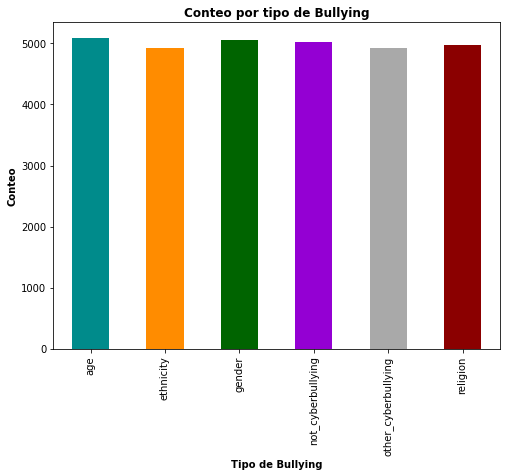

In [38]:
color = ['darkcyan', 'darkorange', 'darkgreen', 'darkviolet', 'darkgray', 'darkred']
fig = plt.figure(figsize=(8,6))
Texto_final.groupby('Tipo_Bullying').Lema_Mayores.count().plot.bar(ylim=0, color=color)
plt.title('Conteo por tipo de Bullying', fontweight = 'bold')
plt.xlabel('Tipo de Bullying', fontweight = 'bold')
plt.ylabel('Conteo', fontweight = 'bold')
plt.show()

# Modelos

In [39]:
tfidf = TfidfVectorizer(sublinear_tf = True, min_df = 5, norm = 'l2', encoding = 'latin-1',
                        ngram_range = (1, 2), stop_words = 'english')

features = tfidf.fit_transform(Texto_final.Lema_Mayores).toarray()
labels = Texto_final.Categoria_ID
features.shape

(30000, 11421)

In [40]:
N = 3
for Tipo_Bullying, Categoria_ID in sorted(Categoria_a_ID.items()):
  features_chi2 = chi2(features, labels == Categoria_ID)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Tipo_Bullying))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'age':
  . Most correlated unigrams:
       . bully
       . high
       . school
  . Most correlated bigrams:
       . bully high
       . school bully
       . high school


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'ethnicity':
  . Most correlated unigrams:
       . fuck
       . dumb
       . nigger
  . Most correlated bigrams:
       . fuck obama
       . dumb fuck
       . dumb nigger


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'gender':
  . Most correlated unigrams:
       . gay
       . rape
       . joke
  . Most correlated bigrams:
       . joke gay
       . gay joke
       . rape joke


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'not_cyberbullying':
  . Most correlated unigrams:
       . nigger
       . que
       . andre
  . Most correlated bigrams:
       . dumb nigger
       . high school
       . kat andre


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'other_cyberbullying':
  . Most correlated unigrams:
       . nigger
       . school
       . blameonenotall
  . Most correlated bigrams:
       . rape joke
       . dumb nigger
       . high school
# 'religion':
  . Most correlated unigrams:
       . christian
       . idiot
       . muslim
  . Most correlated bigrams:
       . radical islamic
       . christian woman
       . islamic terrorism


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [41]:
X_train, X_test, y_train, y_test = train_test_split(Texto_final['Lema_Mayores'],
                                                    Texto_final['Tipo_Bullying'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [42]:
models = [RandomForestClassifier(n_estimators = 200, max_depth = 3, random_state = 0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state = 0)]

CV = 10
cv_df = pd.DataFrame(index = range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring = 'accuracy', cv = CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [43]:
print(clf.predict(count_vect.transform(['@HPluckrose @Feminazi_Front how can you call that inequality? That dynamic exists because it\'s necessary for the existence of our species'])))

['gender']


In [44]:
print(clf.predict(count_vect.transform(['RT @Hazz90TRH Wtf is wrong with all you dumb Ass niggers plankin it whatever the fuck its called don\'t you the white man laughing smh'])))

['ethnicity']


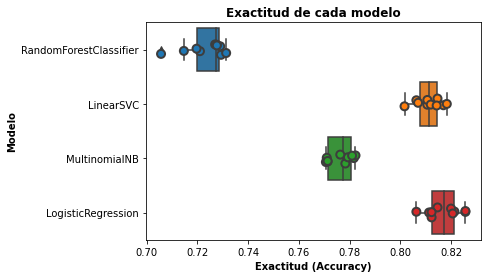

<Figure size 1440x3600 with 0 Axes>

In [56]:
sns.boxplot(x='accuracy', y='model_name', data=cv_df)
sns.stripplot(x='accuracy', y='model_name', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.title('Exactitud de cada modelo', fontweight = 'bold')
plt.xlabel('Exactitud (Accuracy)', fontweight = 'bold')
plt.ylabel('Modelo', fontweight = 'bold')
plt.figure(figsize=(20, 50))
plt.show()

In [47]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.811267
LogisticRegression        0.817033
MultinomialNB             0.776333
RandomForestClassifier    0.723300
Name: accuracy, dtype: float64

In [57]:
model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, Texto_final.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

## Matriz de confusión

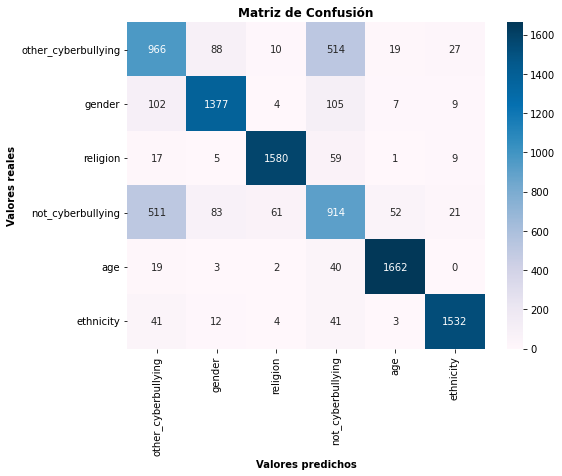

In [59]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=Categoria_ID_datos.Tipo_Bullying.values,
            yticklabels=Categoria_ID_datos.Tipo_Bullying.values, cmap = 'PuBu',
            linecolor = 'black')
plt.title('Matriz de Confusión', fontweight = 'bold')
plt.xlabel('Valores predichos', fontweight = 'bold')
plt.ylabel('Valores reales', fontweight = 'bold')
plt.show()

In [60]:
for predicted in Categoria_ID_datos.Categoria_ID:
  for actual in Categoria_ID_datos.Categoria_ID:
    if predicted != actual and conf_mat[actual, predicted] >= 6:
      print("'{}' predicted as '{}' : {} examples.".format(ID_a_Categoria[actual], ID_a_Categoria[predicted], conf_mat[actual, predicted]))
      display(Texto_final.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Tipo_Bullying', 'Texto']])
      print('')

'gender' predicted as 'other_cyberbullying' : 102 examples.


,Tipo_Bullying,Texto
10794,gender,Kat seriously turn it down... #mkr
4407,gender,"It kills me when men say women should take ""I'..."
11499,gender,bitches hate to see female kpop artists apart ...
20603,gender,RT @deanesmay: I'm not kidding when I say it: ...
22894,gender,@filthy_degen Everything I post is free to be ...
...,...,...
5818,gender,RT @Oneiorosgrip: #adviceforyoungfeminists Lea...
5589,gender,That judge whatever his name needs to stop the...
14277,gender,.@MSharkess @CriticalKelly @MensHumanRights @r...
7002,gender,I HATE KATE &amp; ANDREA #mkr



'religion' predicted as 'other_cyberbullying' : 17 examples.


,Tipo_Bullying,Texto
8073,religion,RT @TheRightWingM: Giuliani watched his city a...
15153,religion,âYou can fool some people some of the time b...
18446,religion,Rob I wish you and EVERYONE a wonderful day. T...
27704,religion,I hope the guy on the phone knows Allah can se...
21289,religion,I support Trump. And did you agree with Naz wh...
1026,religion,@Rubiconski You must be one of Putin's army of...
5210,religion,@mutaSawwif And if you are going to follow a p...
11139,religion,RT @YesYoureRacist: At least you're only a tin...
27176,religion,@suranie Exactly. Merkel is defending this. ...
12598,religion,@DawlatnaMansura The end result being that the...



'not_cyberbullying' predicted as 'other_cyberbullying' : 511 examples.


,Tipo_Bullying,Texto
8225,not_cyberbullying,@Firebomb173 @ANDAASONSAN not the first time i...
252,not_cyberbullying,Follow @SoDamnTrue _ its just so damn true!!!
8156,not_cyberbullying,@LucifersLawyer @DeadpoolPewPew @TechyFolks @S...
18078,not_cyberbullying,Bullying conference is going pretty well. Good...
6590,not_cyberbullying,@harper @korvys it's also a license I know wel...
...,...,...
225,not_cyberbullying,@funjon that's... actually kind of interesting...
8186,not_cyberbullying,YEAH VICTORIA #MKR
27589,not_cyberbullying,Is that weird? Am I doing the right thing? It ...
9953,not_cyberbullying,Pickaxe is the new crowbar. http://t.co/BCSpxT...



'age' predicted as 'other_cyberbullying' : 19 examples.


,Tipo_Bullying,Texto
24174,age,Nah. Lilac was typically the kind of gal that ...
20124,age,RT @AuthorNinaPerez: How about they're ALL nas...
26376,age,Every single one of their stories dealing with...
18031,age,Dido got bullied as a kid for being called Flo...
21261,age,Like seriously you are fucking disgusting. Gro...
14901,age,I WISH you guys would abduct me. Be a lot cool...
28228,age,"Everyone tweeting ""this tweet/ your tweet/ you..."
6261,age,@newby_andrew @sickpics4ever dude it's fucking...
5466,age,"Elsewhere...bullies back to picking on ""real g..."
20356,age,@jpodhoretz there's a scene based on my Dad. T...



'ethnicity' predicted as 'other_cyberbullying' : 41 examples.


,Tipo_Bullying,Texto
728,ethnicity,when u change your answer and realize ur first...
10523,ethnicity,cracked my phone screen which is bad but on th...
29997,ethnicity,RT @Iloveyou12001: I swear niggas get in frate...
29517,ethnicity,RT @onlyashlywould: if yo bestfriend dont call...
27839,ethnicity,listen. ur the one who said she was bad in the...
12664,ethnicity,@No_FAKINGG: People always asking me what I'm ...
13661,ethnicity,not you refusing to like any of my tweets yet ...
6144,ethnicity,RT @nyctophil3: Pineapples do not belong on pi...
4879,ethnicity,RT @ChickenColeman: That nigga needs anger man...
21487,ethnicity,First time in ur coustoms and I place 21 and w...



'other_cyberbullying' predicted as 'gender' : 88 examples.


,Tipo_Bullying,Texto
11291,other_cyberbullying,#BlameOneNotAll bunch of 1st world feminists d...
8859,other_cyberbullying,"@BananaQueeeeen Sorry darlin, not gonna work. ..."
12128,other_cyberbullying,RT @KaledaaRamadani: @Mo_Omer1 @RyanJDoyle97 S...
28757,other_cyberbullying,RT @AlejandroDaGr8: So you basically arrested ...
16212,other_cyberbullying,@GamesafeAU you should try. guyliner is the be...
...,...,...
24082,other_cyberbullying,I May not say it a lot but I hate apologetic A...
18196,other_cyberbullying,@Uictoria33 @jaketapper So yes you could say t...
26662,other_cyberbullying,I fucking NEED this COuntry Girls DVD Magazine...
23427,other_cyberbullying,@Venomous9 my views are largely tempered by my...



'not_cyberbullying' predicted as 'gender' : 83 examples.


,Tipo_Bullying,Texto
3199,not_cyberbullying,Being a feminist can be so incredibly fucking ...
24761,not_cyberbullying,@IHatebd I apologize if I wasn't clear. I thin...
24579,not_cyberbullying,"#YesAllWomen are sick and tired of ""but there'..."
28975,not_cyberbullying,Nikki you should've changed the ballet flats f...
10013,not_cyberbullying,"What kind of shit must you write, honestly, no..."
...,...,...
21930,not_cyberbullying,@syannenicole sucks to suck
16542,not_cyberbullying,@AJBrady_Sports #mkr ??
10438,not_cyberbullying,Will those killer blondes kill the whole dinne...
23503,not_cyberbullying,"When you're on show, don't start making up dis..."



'ethnicity' predicted as 'gender' : 12 examples.


,Tipo_Bullying,Texto
4340,ethnicity,MOTHERFUCKER CUNT SHIT PUSSY ASS NIGGER SLUT 2...
6602,ethnicity,reformed white male kotaku commenter bionicle ...
4738,ethnicity,ur tweet was the first one in âcheritz webto...
18759,ethnicity,@renearroyoo the way people think Iâm you. 1...
15975,ethnicity,"Your right on the first point, Iâll apologis..."
16195,ethnicity,"Klavan, u look like s burglar ffs u stupid Est..."
575,ethnicity,To see if something special was keeping him so...
323,ethnicity,Not ur first think about the camera lenses one...
23132,ethnicity,ohhhhh dhjdfhsk i have no idea mayb like ur fi...
22088,ethnicity,#¿NOMBRE?



'other_cyberbullying' predicted as 'religion' : 10 examples.


,Tipo_Bullying,Texto
29402,other_cyberbullying,Is#Iranian leaders smarter than#Western leader...
28762,other_cyberbullying,"You can express yourself as an asshole, but th..."
9895,other_cyberbullying,RT @miyata_kurisu: All of us right now.
25623,other_cyberbullying,#Arab #nations deeply worried by #Iran #nuke d...
6418,other_cyberbullying,@Isham_AlAssad @UN Nobody said that goat fucke...
23660,other_cyberbullying,#Libya Accuses #US of Trying to Put #Muslim #b...
12885,other_cyberbullying,@Raja5aab @Quickieleaks Now ten dead pussies.
21274,other_cyberbullying,@ShepNewsTeam tell that idiot he didn't decla...
15635,other_cyberbullying,RT @catesish: THEY JUST CROSSED THE STREET AND...
10970,other_cyberbullying,@nzherald Being called an idiot by terrorists ...



'not_cyberbullying' predicted as 'religion' : 61 examples.


,Tipo_Bullying,Texto
4541,not_cyberbullying,@discerningmumin Examples being death for apos...
6847,not_cyberbullying,@kazamaryuji3 If the Palestinians had the abil...
15722,not_cyberbullying,@asem_1994 And 100% of Jews and Christians wer...
2446,not_cyberbullying,"@discerningmumin But regardless, ISIS will be ..."
24711,not_cyberbullying,"@ummayman90 Richard II is nobody's prophet, mi..."
...,...,...
10549,not_cyberbullying,@ingyusarms Here is a philosophical exercise f...
9057,not_cyberbullying,@AllooCharas @RudawEnglish The US has never ha...
13927,not_cyberbullying,@CooleyOnEurasia @UmarFarooq_ You can be sure ...
9335,not_cyberbullying,RT @Rjrasva: Turkey going as expected: http://...



'other_cyberbullying' predicted as 'not_cyberbullying' : 514 examples.


,Tipo_Bullying,Texto
14161,other_cyberbullying,@_FamoussCam Ã°ÂÂÂdamn y'all feeling me ain...
7631,other_cyberbullying,RT @max2000warlord: @freebsdgirl I highly doub...
14341,other_cyberbullying,@Shervyn I think the biggest challenge going f...
1687,other_cyberbullying,@DataFran it definitely alienates female reade...
8953,other_cyberbullying,Leo is stoic as he guards me for the night. ht...
...,...,...
14562,other_cyberbullying,Thought you might find this amusing. http://t....
25137,other_cyberbullying,That was a comment taken from Polygon's articl...
28939,other_cyberbullying,"@WBrokenbourgh I use it on AWS constantly, but..."
27213,other_cyberbullying,THISE NOISES WHILE HE IS WAGGING HIS TAIL. wtf...



'gender' predicted as 'not_cyberbullying' : 105 examples.


,Tipo_Bullying,Texto
22050,gender,*cough* slut *cough #MKR
29798,gender,RT @darthkbub Give your daughters a fighting c...
5821,gender,#IndiasDaughter
20117,gender,"I'm be buying training bras soon, dealing with..."
3539,gender,If I went to get breakfast and I was served by...
...,...,...
19791,gender,Kat should be eliminated for bad sportsmanship...
9205,gender,#mkr http://t.co/x84Kâ¦
25913,gender,Can we set up a 'let Andre escape from Kat' ch...
16664,gender,"@OfficMattPenny @IrkMeIngram Ah, I see. Men ""r..."



'religion' predicted as 'not_cyberbullying' : 59 examples.


,Tipo_Bullying,Texto
20730,religion,@watan71969 @geeky_zekey And looking at your p...
23501,religion,"@seekingjannah3 @Citywolf_IS3 @Censored31 Yes,..."
23955,religion,@obsurfer84 The ME led the world in developmen...
22935,religion,@joedalton2015 @scamp_faridxx The reason that ...
19409,religion,@End_Bigotry @chezkig1 @edulixavot34 @georgega...
24226,religion,RT @curdistani: ISIS trying to stop people fle...
23127,religion,Watching Shia Militia beat a Peshmerga to deat...
28544,religion,"RT @PatDollard: The #Ferguson ""crisis"" was man..."
6126,religion,@asem_1994 Good morning. Here is the history ...
6491,religion,@jihadi_11 @Shami_IS_back When the filthy Daes...



'age' predicted as 'not_cyberbullying' : 40 examples.


,Tipo_Bullying,Texto
28037,age,"YOU KNOW TODAY A HOLIDAY, MY TL JUMPING EARLY...."
25860,age,'Far left bully boys' This from the underprivi...
29931,age,His math team understands math when lining the...
17457,age,Oh man. I was the toxic bully of everyone's ni...
12505,age,">:( That's not a peer, that's a bully. I faile..."
15396,age,@ReasonVsFear I guess it's this...I was SO bea...
651,age,Tje clps on peel scholl dont care abt cyber bu...
19988,age,i see i see! i am very fucking horrible at mat...
23950,age,What favor has BLM provided us with? What have...
12924,age,To have led the body that does not possess any...



'ethnicity' predicted as 'not_cyberbullying' : 41 examples.


,Tipo_Bullying,Texto
24162,ethnicity,"they talking bout a riot today , cause its the..."
1402,ethnicity,if u could go back and relive the first time h...
10054,ethnicity,@NewEraJihadi @ShamiAnalyst You are too pussy ...
9129,ethnicity,"@Ernesto_RS1 My niggas is savage, ruthless. We..."
6569,ethnicity,#beachbodyready http://t.co/nTAnxTG50h
20938,ethnicity,RT @jayy100k_: Idgaf what my shorty wear cause...
4114,ethnicity,"Ideally,When we go for Darshan,we need to see ..."
28025,ethnicity,Figures...the problem with the âitâs just ...
15131,ethnicity,ur first one it just fits
3427,ethnicity,ooooo is this ur first one?



'other_cyberbullying' predicted as 'age' : 19 examples.


,Tipo_Bullying,Texto
16275,other_cyberbullying,The mean bully girl from the old neighborhood ...
19303,other_cyberbullying,Misinterpreting the report that poorly makes m...
15263,other_cyberbullying,"My mama just told Louis ""Stop barking and tryi..."
1630,other_cyberbullying,Nobody should bully a sweet girl like @Amellia...
3787,other_cyberbullying,@scm ooo. that's old school. i didn't even thi...
6107,other_cyberbullying,A girl who bullied me this entire school year ...
2403,other_cyberbullying,@ClareTGG HAHHAHAH! Her last name is Hooker? P...
25190,other_cyberbullying,@No_kamryn oh that sounds worse than my bully....
23410,other_cyberbullying,#WWYD if You saw the kids who bullied MB?
10703,other_cyberbullying,70. I used to be bullied badly at school #100f...



'gender' predicted as 'age' : 7 examples.


,Tipo_Bullying,Texto
19053,gender,"#DesiPorn,#ManDingo,#AsianButts,#Aunty,#Mature..."
19782,gender,DID U WRITE THAT URSELF OMG @joeldanger All gi...
8698,gender,RT @Matt2theRios: Hats off to girls who light ...
6484,gender,@Lesleywallace1: #QuestionsForMen Have you bee...
10748,gender,oh sorry i dont date girls who are taller than me
23287,gender,theyre either pale af skinny girls that look l...
23862,gender,I hope a girl views me like this because damn ...



'not_cyberbullying' predicted as 'age' : 52 examples.


,Tipo_Bullying,Texto
7675,not_cyberbullying,Banana Phone was freshman-in-high-school-me's ...
22100,not_cyberbullying,"@FUCKyou_imCUte damn forreal , I go to a priva..."
24844,not_cyberbullying,Lmfao he stole ur girl so u put him on bully b...
15077,not_cyberbullying,Even when there's no school I still get up bef...
6307,not_cyberbullying,@colinsines Hope ur health is better &amp; ur ...
24692,not_cyberbullying,@ErikahhhGeee I told my mom about how I'm Rud...
22365,not_cyberbullying,Left my good pillow at school #faahk #PreSchoo...
19916,not_cyberbullying,He embellished the afternoon with moustachioed...
11530,not_cyberbullying,@persu_ASIA_n oh nun watchn football n bouta g...
275,not_cyberbullying,To think that we don't have to go to school on...



'other_cyberbullying' predicted as 'ethnicity' : 27 examples.


,Tipo_Bullying,Texto
4273,other_cyberbullying,"Frank, with a bullied past, calls Jacques ""Joc..."
24990,other_cyberbullying,If you see your friends doing nothing but ragi...
14115,other_cyberbullying,RT @sideniggajoel: Lmaooo on god if you believ...
29639,other_cyberbullying,"truly honored that I just got called a ""femina..."
10390,other_cyberbullying,@MorseLyA hehe. That was actually super helpfu...
7099,other_cyberbullying,"Like, we've all got our own shit happening, bu..."
3103,other_cyberbullying,@KingsDartWars hey guys. Get the money ready f...
23106,other_cyberbullying,RT @deadhomosexual: beat my ass if i ever let ...
15606,other_cyberbullying,RT @lilbeastunleash: its melting because you d...
27714,other_cyberbullying,@onebrightlight they made mistakes in the past...



'gender' predicted as 'ethnicity' : 9 examples.


,Tipo_Bullying,Texto
8381,gender,@thegeek_chick No. You have proven your ignora...
4536,gender,Although Donald Glover has been pretty problem...
17857,gender,@KidCollins_ @samkuebler @zzoegrimm man fuck t...
29479,gender,#mkr The only thing these promo girls are goin...
6704,gender,like Snoop said in 94 we dont love these hoes
17456,gender,First off someone get this dumb bitch a mask a...
19133,gender,RT @KeepItGulley: Its always funny seeing whit...
20526,gender,"Iâm sorry, Insatiable (bad jokes about rape ..."
17882,gender,Lmao you can keep that kinda maturity. I call ...



'religion' predicted as 'ethnicity' : 9 examples.


,Tipo_Bullying,Texto
14945,religion,Amazing how Reuben never seems to get anybody ...
4898,religion,First impression of you : an idiot admin in te...
19975,religion,@JoRitson Pieces of shit like you are doing ev...
18762,religion,"He can't be a server at our restaurant, that b..."
25750,religion,You tell me everything I need to know by your ...
121,religion,"OMG, a YouTube video!?! That exposes the plot ..."
24985,religion,Somalis arenât black. So many Arabs and Asia...
17761,religion,#BlackLivesMatter!!! except... the vast majori...
2577,religion,@Jihadii8 @AkEl_Saruman No he's not. He's an ...



'not_cyberbullying' predicted as 'ethnicity' : 21 examples.


,Tipo_Bullying,Texto
23304,not_cyberbullying,Just when you think youve truly escaped guys f...
18216,not_cyberbullying,@daarulislam_com Racism in Islam. http://t.co/...
28247,not_cyberbullying,"White people and culturally appropriative ""spi..."
6029,not_cyberbullying,@Ravavilad_film Dont' we know it!
10481,not_cyberbullying,@KearaCharise lol im bouta text yu in 3.67 sec...
22475,not_cyberbullying,@Te4m_NiGhtM4Re WHAT COLOR IS THE SKY IN YOUR ...
20034,not_cyberbullying,brand new day
23523,not_cyberbullying,Emanuel in love.... I gotta tell quinton bout ...
14105,not_cyberbullying,RT @GrumpyPigeon: I'm thinking #MKR will go pa...
23936,not_cyberbullying,Nuttin ain't gonna happen to my nigg she can h...


In [61]:
model.fit(features, labels)

N = 3
for Tipo_Bullying, Categoria_ID in sorted(Categoria_a_ID.items()):
  indices = np.argsort(model.coef_[Categoria_ID])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Tipo_Bullying))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'age':
  . Top unigrams:
       . school
       . high
       . girl
  . Top bigrams:
       . school bully
       . bully school
       . bully high
# 'ethnicity':
  . Top unigrams:
       . nigger
       . negro
       . dumb
  . Top bigrams:
       . dumb fuck
       . dumb nigger
       . look stupid
# 'gender':
  . Top unigrams:
       . rape
       . gay
       . sexist
  . Top bigrams:
       . rape joke
       . sexist woman
       . male friend
# 'not_cyberbullying':
  . Top unigrams:
       . yesallwomen
       . putin
       . benpobjie
  . Top bigrams:
       . kid like
       . anti bully
       . video youtube
# 'other_cyberbullying':
  . Top unigrams:
       . idiot
       . blameonenotall
       . taurmaurils
  . Top bigrams:
       . man black
       . bully little
       . year bully
# 'religion':
  . Top unigrams:
       . muslim
       . radical
       . christian
  . Top bigrams:
       . christian woman
       . islamic terrorism
       . âchristianâ woman


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Predicción

In [62]:
# etnico
# religion
# no ciberbullying
# age
# other_cyberbullying
texts = ['@LoLosWay I don\'t want to see a pic of your dumb nigger ass bitch fuck off',
         'Tweeting about the Muslim brotherhood and turkey and talking shit is good sport, you will have hoards of brainless idiots storming your feed',
         'RT @OliveWahh: The scoring wasn\'t even done honestly #MKR',
         'Tzuyu looked like a genius high school girl from a kdrama who\'s always bullied but always saved by two handsome campus crushes',
         'why on earth did i take this god awful fucking shift oh my god']
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(ID_a_Categoria[predicted]))
  print("")

"@LoLosWay I don't want to see a pic of your dumb nigger ass bitch fuck off"
  - Predicted as: 'ethnicity'

"Tweeting about the Muslim brotherhood and turkey and talking shit is good sport, you will have hoards of brainless idiots storming your feed"
  - Predicted as: 'religion'

"RT @OliveWahh: The scoring wasn't even done honestly #MKR"
  - Predicted as: 'not_cyberbullying'

"Tzuyu looked like a genius high school girl from a kdrama who's always bullied but always saved by two handsome campus crushes"
  - Predicted as: 'age'

"why on earth did i take this god awful fucking shift oh my god"
  - Predicted as: 'other_cyberbullying'



In [63]:
print(Texto_final['Tipo_Bullying'].unique())

['other_cyberbullying' 'gender' 'religion' 'not_cyberbullying' 'age'
 'ethnicity']


In [64]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.59      0.59      1624
           1       0.88      0.86      0.87      1604
           2       0.95      0.95      0.95      1671
           3       0.55      0.56      0.55      1642
           4       0.95      0.96      0.96      1726
           5       0.96      0.94      0.95      1633

    accuracy                           0.81      9900
   macro avg       0.81      0.81      0.81      9900
weighted avg       0.81      0.81      0.81      9900

